/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral/pre_smnwrf_2024120102_anomPrec_wrf.png


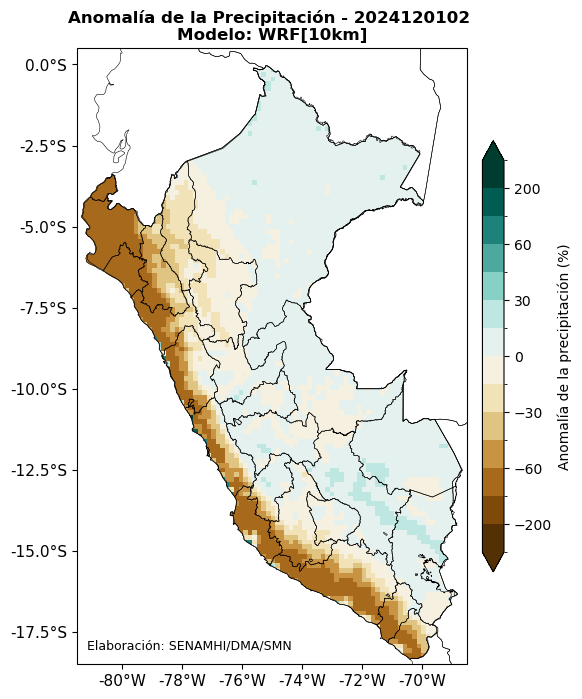

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os

base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Rutas de los archivos NetCDF
archivo_pronostico = f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/lluvia/mes_ensemble_pp_peru.nc"
archivo_climatologia = f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/lluvia/prom.pp.clima.nc"

# Rutas de los shapefiles
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'

# Cargar los shapefiles
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)
peru = gpd.read_file(ruta_shapefile_peru)

# Verificar si el CRS coincide y transformar si es necesario
if sudamerica.crs != peru.crs:
    sudamerica = sudamerica.to_crs(peru.crs)

# Abrir los archivos NetCDF sin decodificar el tiempo
ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

# Extraer el año y mes base desde los atributos de 'time'
time_units = ds_pronostico['time'].attrs['units']
fecha_base_str = time_units.split('since')[-1].strip()
fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

# Acceder a las variables de precipitación (variable 'p')
pronostico_lluvia = ds_pronostico['p']
climatologia_lluvia = ds_climatologia['p']

# Definir los niveles personalizados
# Definir los niveles personalizados
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])
norm = BoundaryNorm(niveles, ncolors=256)

# Seleccionar los tiempos correspondientes a mes1, mes2, mes3
pronostico_lluvia_trimestre = pronostico_lluvia.isel(time=slice(0, 3)).mean(dim='time')
climatologia_lluvia_trimestre = climatologia_lluvia.isel(time=slice(0, 3)).mean(dim='time')

# Calcular la anomalía porcentual de la precipitación para el trimestre
anomalia_porcentual_lluvia_trimestre = ((pronostico_lluvia_trimestre - climatologia_lluvia_trimestre) / climatologia_lluvia_trimestre) * 100

# Calcular las fechas correspondientes a los tres meses del trimestre
fechas_reales = [add_months_to_date(fecha_base, int(ds_pronostico['time'].isel(time=i).values)) for i in range(0, 3)]

# Formatear la fecha en el formato YYYYmes1mes2mes3
fecha_str = f'{fechas_reales[0].year}{fechas_reales[0].month:02d}{fechas_reales[1].month:02d}{fechas_reales[2].month:02d}'

# Crear la carpeta para guardar los gráficos basada en la fecha del primer mes del trimestre
#carpeta_trimestre = f'{fechas_reales[0].year}{fechas_reales[0].month:02d}'
ruta_carpeta = f'/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral'

if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)

# Graficar la anomalía porcentual para el trimestre
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Definir los límites geográficos para Perú
lon_min, lon_max = -81.5, -68.5
lat_min, lat_max = -18.5, 0.5

# Graficar la anomalía porcentual del trimestre
img = anomalia_porcentual_lluvia_trimestre.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', norm=norm, add_colorbar=False)

# Configurar los límites del mapa para Perú
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Añadir shapefiles de Sudamérica y Perú
sudamerica.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)
peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

# Añadir shapefile de Sudamérica sin Perú
sudamerica_noperu = gpd.read_file(ruta_shapefile_sudamerica)
sudamerica_noperu.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.1, zorder=1)

# Añadir la barra de colores
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, extend='both', shrink=0.7, aspect=20)
cbar.set_label('Anomalía de la precipitación (%)')

# Configurar las etiquetas de latitud y longitud
ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
# Ajustar el tamaño de la fuente de los ticks en los ejes
ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor

# Añadir nombres a los ejes
ax.set_xlabel('')
ax.set_ylabel('')
# Añadir la leyenda de texto en la parte inferior derecha
ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=9, color='black', 
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Añadir el título utilizando los meses correspondientes al trimestre
plt.title(f'Anomalía de la Precipitación - {fecha_str} \nModelo: WRF[10km]', fontsize=12, fontweight='bold')

# Guardar el gráfico
nombre_archivo = f'pre_smnwrf_{fecha_str}_anomPrec_wrf.png'
ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
print(ruta_archivo)
plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()
